In [28]:
import torchvision
import torch
import matplotlib.pyplot as plt

class AddGaussianNoise(object):
  def __init__(self, mean=0, var=0.3):
    self.mean = mean
    self.var = var

  def __call__(self, tensor):
    tensor = tensor + torch.randn(tensor.size()) * self.var +self.mean
    tensor = torch.clip(tensor, min = 0, max = 1)
    return tensor


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

100%|██████████| 9912422/9912422 [00:00<00:00, 437901806.81it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35523663.88it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 119716308.00it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5308032.53it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



1.0
0.0


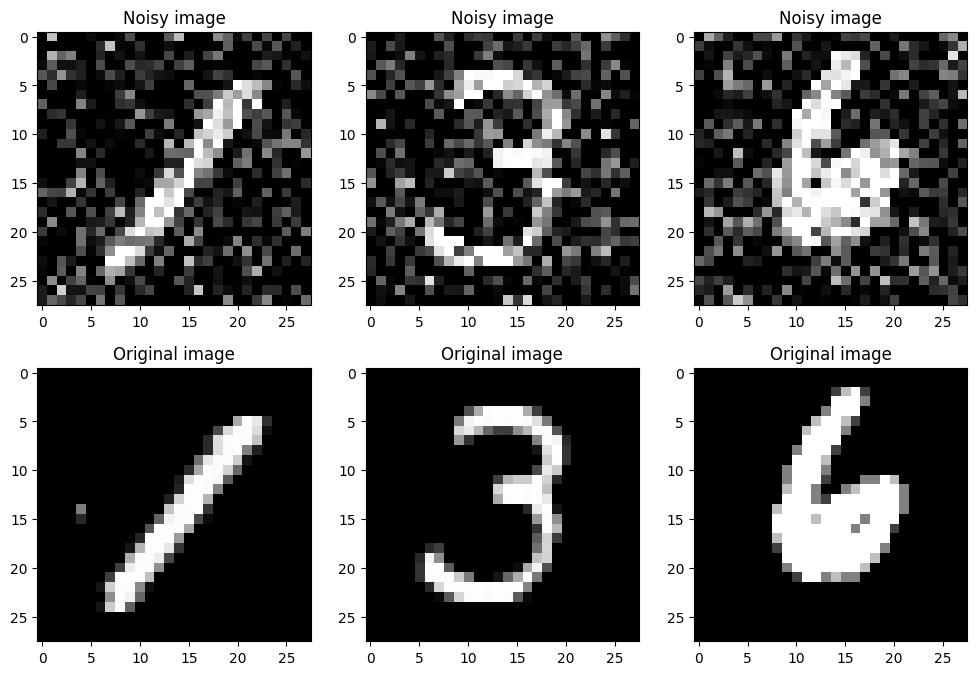

In [29]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

# Plot the 3 training images with corresponding noisy images 
_,(gaussian, original) = next(enumerate(train_loader))
fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(gaussian[idx][0], cmap='gray')
  ax[0,idx].set_title(f'Noisy image')
  ax[1,idx].imshow(original[idx][0], cmap='gray')
  ax[1,idx].set_title(f'Original image')
fig.show()

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

latent_feature = 16
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')
class noisy_images_model(nn.Module):
  def __init__(self):
    super(noisy_images_model, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=270)
    self.en_fc3 = nn.Linear(in_features=270, out_features=latent_feature)

    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=270)
    self.de_fc2 = nn.Linear(in_features=270, out_features=512)
    self.de_fc3 = nn.Linear(in_features=512, out_features=784)

  def forward(self, x):

    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = F.relu(self.en_fc2(x))
    x = F.relu(self.en_fc3(x))

    # decoding layers
    x = F.relu(self.de_fc1(x))
    x = F.relu(self.de_fc2(x))
    x = torch.sigmoid(self.de_fc3(x))
    x = x.view(-1, 1, 28, 28)
    return x


We are using device name "cuda"


In [33]:
AE = noisy_images_model().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch, device):

  AE.train() 

  for batch_idx, (gaussian, original) in enumerate(train_loader):
    optimizer.zero_grad()
    gaussian = gaussian.to(device)
    original = original.to(device)
    output = AE(gaussian)
    loss = loss_fn(output, original) 
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: 
      train_losses.append(loss.item()/batch_size_train) 
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: 
      print(f'Epoch {epoch}: [{batch_idx*len(gaussian)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() 

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, original in test_loader:
      images = images.to(device)
      original = original.to(device)
      output = AE(images)
      test_loss += loss_fn(output, original).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

In [34]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

Epoch 1: [0/60000] Loss: 180.82369995117188
Epoch 1: [6400/60000] Loss: 56.43556594848633
Epoch 1: [12800/60000] Loss: 53.67818832397461
Epoch 1: [19200/60000] Loss: 54.65460968017578
Epoch 1: [25600/60000] Loss: 51.27277755737305
Epoch 1: [32000/60000] Loss: 48.95967102050781
Epoch 1: [38400/60000] Loss: 47.011112213134766
Epoch 1: [44800/60000] Loss: 45.37109375
Epoch 1: [51200/60000] Loss: 44.91362762451172
Epoch 1: [57600/60000] Loss: 38.08991622924805
Test result on epoch 1: Avg loss is 38.65107890625
Epoch 2: [0/60000] Loss: 38.7984619140625
Epoch 2: [6400/60000] Loss: 40.687618255615234
Epoch 2: [12800/60000] Loss: 36.25528335571289
Epoch 2: [19200/60000] Loss: 31.109573364257812
Epoch 2: [25600/60000] Loss: 31.262359619140625
Epoch 2: [32000/60000] Loss: 28.138214111328125
Epoch 2: [38400/60000] Loss: 28.707496643066406
Epoch 2: [44800/60000] Loss: 30.741605758666992
Epoch 2: [51200/60000] Loss: 26.8651065826416
Epoch 2: [57600/60000] Loss: 24.220142364501953
Test result on epo

torch.Size([1000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


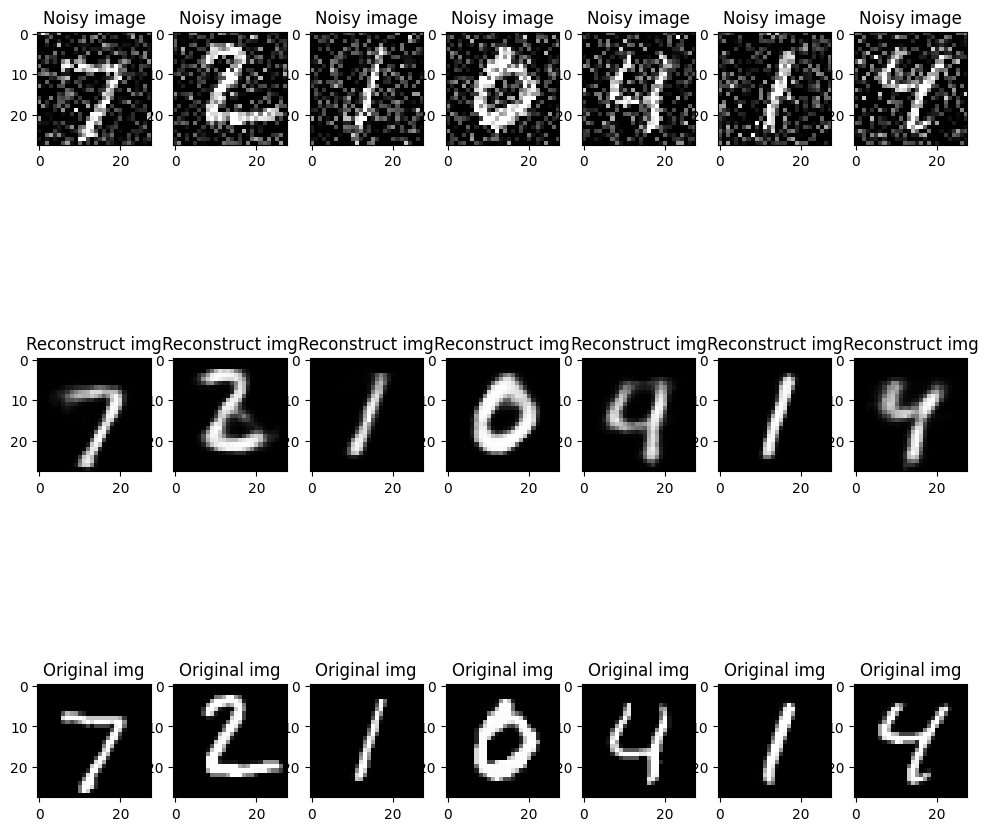

In [38]:
import matplotlib.pyplot as plt

batch_idx, (images, _) = next(enumerate(test_loader))
images = images.to(device)
output = AE(images).cpu().detach()
images = images.cpu()
print(images.size(), output.size())

fig, ax = plt.subplots(3,7)
fig.set_size_inches(12,12)

for idx in range(7):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[0,idx].set_title(f'Noisy image')
  ax[1,idx].imshow(output[idx][0], cmap='gray')
  ax[1,idx].set_title(f'Reconstruct img')
  ax[2,idx].imshow(_[idx][0], cmap='gray')
  ax[2,idx].set_title(f'Original img')
fig.show()

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [20]:
#this function will add noise to the MINST classes
def add_noise(y, noise_factor=0.25):
    num_samples, num_classes = y.shape
    noise = np.random.uniform(size=(num_samples, num_classes))
    y_noisy = (1 - noise_factor) * y + noise_factor * noise
    y_noisy = y_noisy / np.sum(y_noisy, axis=1, keepdims=True)
    return y_noisy

y_train_noisy = add_noise(y_train)

In [21]:
print(y_train)
print(y_train_noisy)
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0.03018765 0.0962685  0.01581299 ... 0.04541463 0.03810619 0.09994766]
 [0.43596515 0.07700146 0.09602459 ... 0.02380299 0.06493288 0.04531175]
 [0.05297333 0.03104535 0.03539174 ... 0.01183067 0.04925698 0.08748645]
 ...
 [0.00471768 0.06365342 0.12698857 ... 0.05672042 0.0371169  0.05743512]
 [0.0025491  0.08509339 0.04517242 ... 0.05393868 0.10907951 0.06457243]
 [0.05186051 0.03494586 0.01025826 ... 0.12004335 0.40157834 0.04881849]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
def noisy_labels_model(input_shape, num_classes):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

input_shape = x_train.shape[1:]
model = noisy_labels_model(input_shape, num_classes)

In [23]:
batch_size = 128
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train_noisy, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/20
422/422 [==============================] - 3s 4ms/step - loss: 2.0150 - accuracy: 0.8995 - val_loss: 1.9596 - val_accuracy: 0.9812
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 1.9710 - accuracy: 0.9680 - val_loss: 1.9503 - val_accuracy: 0.9848
Epoch 3/20
422/422 [==============================] - 1s 3ms/step - loss: 1.9636 - accuracy: 0.9748 - val_loss: 1.9456 - val_accuracy: 0.9873
Epoch 4/20
422/422 [==============================] - 1s 3ms/step - loss: 1.9596 - accuracy: 0.9780 - val_loss: 1.9426 - val_accuracy: 0.9888
Epoch 5/20
422/422 [==============================] - 1s 3ms/step - loss: 1.9572 - accuracy: 0.9801 - val_loss: 1.9424 - val_accuracy: 0.9895
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 1.9559 - accuracy: 0.9811 - val_loss: 1.9407 - val_accuracy: 0.9900
Epoch 7/20
422/422 [==============================] - 1s 4ms/step - loss: 1.9541 - accuracy: 0.9827 - val_loss: 1.9399 - val_accuracy: 0.9903
Epoch 

In [24]:
print(history.history)

{'loss': [2.0150113105773926, 1.971045970916748, 1.963635802268982, 1.959593415260315, 1.9571533203125, 1.9558765888214111, 1.9541290998458862, 1.9536494016647339, 1.9532921314239502, 1.952217698097229, 1.9518563747406006, 1.9511901140213013, 1.9510811567306519, 1.9504984617233276, 1.9500038623809814, 1.949721097946167, 1.949601173400879, 1.9489436149597168, 1.9487767219543457, 1.9485341310501099], 'accuracy': [0.8994629383087158, 0.9679814577102661, 0.9747592806816101, 0.9779815077781677, 0.9801481366157532, 0.9810925722122192, 0.9827222228050232, 0.9827222228050232, 0.982796311378479, 0.9843703508377075, 0.9843888878822327, 0.9842592477798462, 0.9846110939979553, 0.9850741028785706, 0.9855926036834717, 0.9852592349052429, 0.9857777953147888, 0.9867963194847107, 0.9862777590751648, 0.9861851930618286], 'val_loss': [1.95957612991333, 1.9502978324890137, 1.9455610513687134, 1.9426058530807495, 1.942414402961731, 1.9407374858856201, 1.939900279045105, 1.940335988998413, 1.939067244529724

In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.93208909034729
Test accuracy: 0.9890999794006348


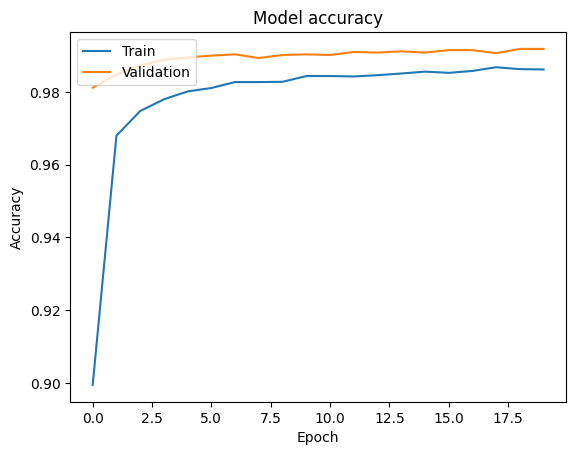

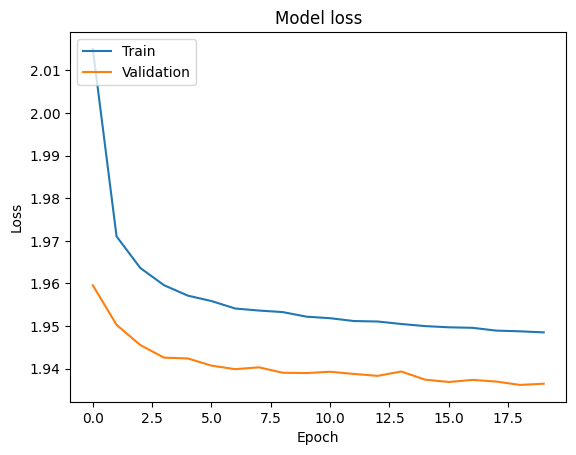

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

313/313 [==============================] - 1s 1ms/step
[[0.06086032 0.05193096 0.05731933 ... 0.47214064 0.06337555 0.05483928]
 [0.1052047  0.08551943 0.31267574 ... 0.05553949 0.06067848 0.07582851]
 [0.05786705 0.44528157 0.05331924 ... 0.06504153 0.06559759 0.05727043]
 ...
 [0.05217476 0.06647614 0.03505391 ... 0.06548596 0.07587884 0.05382439]
 [0.06804256 0.04824177 0.06136806 ... 0.0648459  0.09638305 0.06023706]
 [0.06967505 0.05750143 0.0703297  ... 0.0699876  0.08189365 0.0727253 ]]


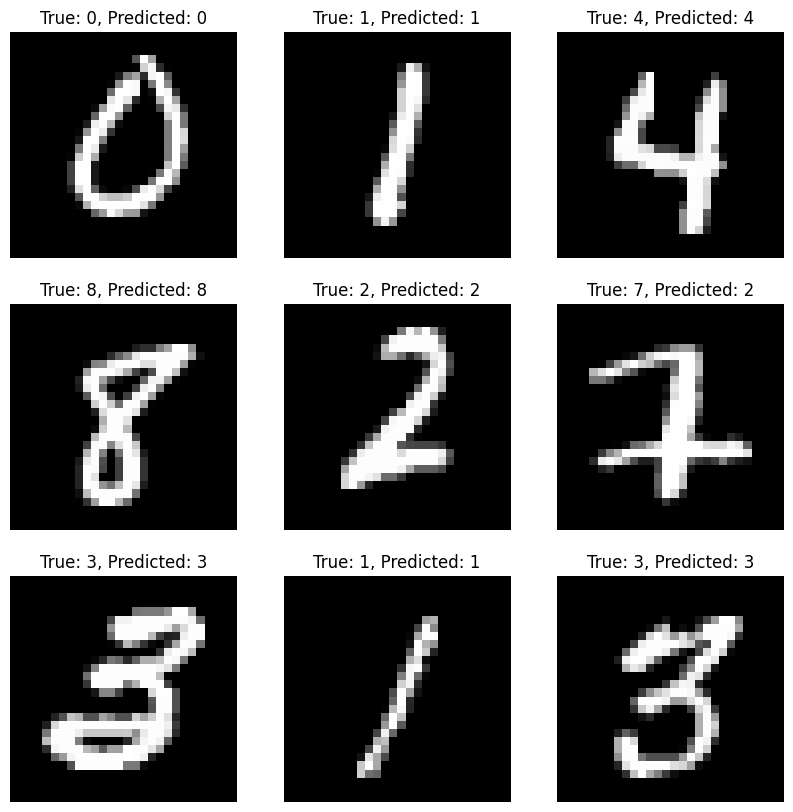

In [27]:
# Obtain predictions for the test set
predictions = model.predict(x_test)
print(predictions)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Visualize the output
num_images_to_show = 9
random_indices = np.random.choice(len(x_test), num_images_to_show, replace=False)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_labels[idx]}, Predicted: {predicted_labels[idx]}")
    plt.axis('off')

plt.show()
